<a href="https://colab.research.google.com/github/joyeetadey/HSI-classification-with-3D-CNN-using-DARTS/blob/main/Transformer_Reduction_HSI_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"


!wget "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"

--2023-01-09 12:41:59--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2023-01-09 12:42:00--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  2.18MB/s    in 2.6s    

2023-01-09 12:42:03 (2.18 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-01-09 12:42:03--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.e

In [3]:
!pip install hy-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 KB 28.6 MB/s eta 0:00:00


In [4]:
import hytools as ht

#Create a HyTools container object
hy_obj = ht.HyTools()

In [7]:
import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode

from numpy.core.fromnumeric import shape
from skimage.morphology import reconstruction
from sklearn.preprocessing import QuantileTransformer


import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import pandas as pd
import time
import seaborn as sn

init_notebook_mode(connected=True)
%matplotlib inline


In [29]:
from scipy.io import loadmat
def loadData():
   data = loadmat('/content/Indian_pines_corrected.mat')['indian_pines_corrected']
   labels = loadmat('/content/Indian_pines_gt.mat')['indian_pines_gt']
   return data, labels

In [13]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [14]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [15]:
def projection_matrix(X, orgin, numComponents):

  # Calculate the covariance matrix first
  
  correlation_matrix = np.corrcoef(orgin.T)
 
  covariance_matrix = np.cov(X.T)   # The result is a Positive semidefinite matrix
  
  final_matrix = covariance_matrix - correlation_matrix
  
  # Eigendecomposition of the covariance
  eigen_values, eigen_vectors = np.linalg.eig(final_matrix)
  # Calculate the variance explained on each of those components
  variance_explained = [(i/sum(eigen_values))*100 for i in eigen_values]
  # Calculate the cumulative sum of variance explained
  cumulative_variance_explained = np.cumsum(variance_explained)
  #Taking two components and create a projection matrix
  projection_matrix = (eigen_vectors.T[:][:numComponents]).T
  
  # Calculate the product of X (standardized original data multiply by eigenvectors)

  X_w = X.dot(projection_matrix)

  return X_w

In [16]:
def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']

  return df

In [59]:
def ETR(X1, y1, band_no, status = 'max', min_no = 1, numComponents=15):
  df = extract_pixels(X1, y1)
  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]

  X = projection_matrix(X,X.iloc[:, :], numComponents)
  print(X)
  # the second step of the ETR method
  X_mean = X
  X_mean['mean'] = X_mean.max(axis=1)* min_no

  Avr = [X_mean['mean']]
  rep_Avr = np.repeat(Avr, numComponents)
  rep_Avr =np.reshape(rep_Avr, (-1,numComponents))
  main_X = X.iloc[:, :-1]
  seed = main_X - rep_Avr

  dilated = reconstruction(seed.values, main_X.values)    

  scaler = QuantileTransformer(n_quantiles=15, random_state=0,output_distribution='normal') #
  scaler = scaler.fit_transform(dilated)
  print(scaler)
  return scaler, y 

In [45]:
dataset = 'IP'
numComponents = 50
test_ratio = 0.8
windowSize = 15
X, y11 = loadData()
h1 = X.shape[0]
w1 = X.shape[1]
band_no = X.shape[2]
X.shape, y11.shape

((145, 145, 200), (145, 145))

In [31]:
h1

145

In [32]:
w1

145

In [34]:
padWithZeros(X)

array([[[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [3172., 4142., 4506., ..., 1057., 1020., 1020.],
        ...,
        [3172., 3890., 4316., ..., 1043., 1034., 1016.],
        [   0.,    0.,    0., ...,    0.,    

In [36]:
createImageCubes(X,y11)

(array([[[[   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    0.,    0.]],
 
         [[   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    0.,    0.]],
 
         [[   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    0.,    0.],
          [3172., 4142., 4506., ..., 1057., 1020., 1020.],
          [2580., 4266., 4502., ..., 1064., 1029., 1020.],
          [3687., 4266., 4421., ..., 1061., 1030., 1016.]],
 
         [[   0.,    0.,    0., ...,    0.,    0.,    0.],
          [   0.,    0.,    0., ...,    0.,    

In [61]:
df = extract_pixels(X,y11)
df

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,...,1013,1012,1018,1015,1011,1001,1000,1009,1008,0
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,...,1012,1014,1012,1024,998,1010,1006,1000,1000,0
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,...,1016,1015,1016,1021,1008,1019,1003,1008,1000,0
21023,3155,4104,4106,4027,4139,4318,4413,4174,4140,3933,...,1005,1011,1008,1012,1014,1007,1011,1005,1003,0


In [77]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 50), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

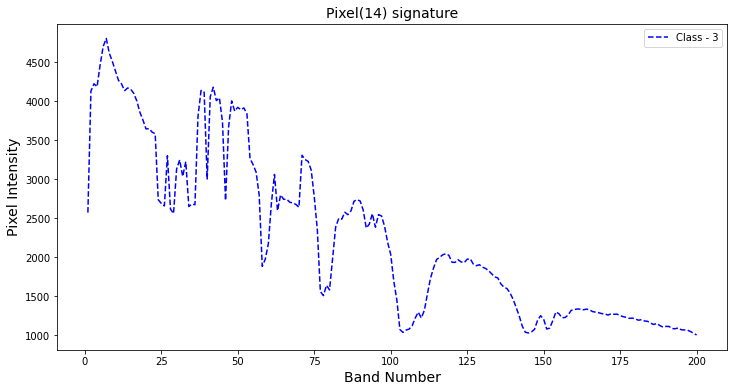

In [69]:
plot_signature(df)

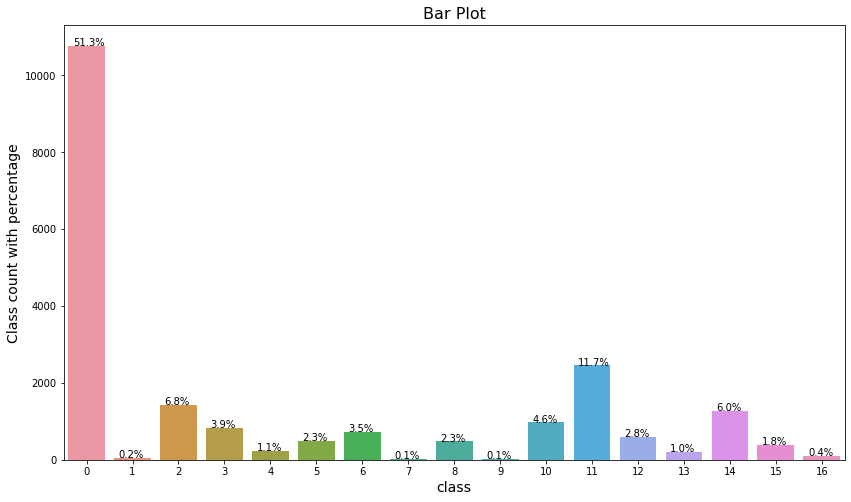

In [71]:
import seaborn as sns
plt.figure(figsize=(14, 8))

ax = sns.countplot(x='class', data=df[['class']])

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df.shape[0]), (p.get_x()+0.1, p.get_height()+5))
#ax.yaxis.set_major_locator(ticker.LinearLocator(11))

plt.ylabel('Class count with percentage', fontsize=14)

plt.xlabel('class', fontsize=14)

plt.title('Bar Plot', fontsize=16)

plt.show()

In [73]:
df = extract_pixels(X, y11)
X1 = df.iloc[:, :-1]
y1 = df.iloc[:, -1]
proj_df = projection_matrix(X1,X1.iloc[:, :], numComponents)
proj_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-8599.139470,38930.687321,3836.298276,-3953.688608,-1360.159389,230.147125,-4221.089933,1944.607851,4064.958932,577.723497,...,-535.734209,-132.713748,1303.331765,710.519017,407.369907,-65.381361,244.045647,-83.078194,822.299185,-344.233618
1,-9185.617097,42411.001233,3558.867576,-3354.027636,-1943.947792,10.637976,-4289.248328,1399.373850,3333.621151,737.714080,...,-516.705251,-117.168845,1250.108697,659.921127,488.613686,-27.775815,250.960987,-44.930347,827.513174,-342.273912
2,-9380.368687,43477.946064,3418.460115,-3122.282637,-2055.797514,167.381649,-4259.212579,1434.301210,4380.989763,452.660956,...,-525.538702,-131.562517,1223.625365,598.429818,570.296629,-45.557284,212.638326,-95.971075,831.284834,-332.974597
3,-9170.437766,42756.927129,3552.725349,-3379.805915,-1942.415004,-7.687271,-4337.360340,1405.246801,3494.451934,699.176895,...,-523.215454,-153.788707,1264.532079,685.900145,439.349799,-62.999380,234.692574,-52.956359,872.000125,-323.647651
4,-8605.223975,40047.946996,3932.003198,-3789.925648,-1427.355340,-139.281628,-4588.998126,1985.775183,3620.165344,576.804135,...,-466.767362,-172.238477,1336.889597,751.324603,333.122589,-86.924862,229.744118,-89.049303,922.022539,-312.432833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,3903.320257,42193.227601,3631.403918,-4105.730246,-1722.346898,247.209893,-4393.450327,1950.404205,3394.545330,745.088193,...,-472.090349,-153.040885,1176.719378,552.948915,499.819508,-41.801855,255.133397,-94.580013,942.116925,-334.083706
21021,4163.291160,42219.458141,3509.492478,-3973.543025,-1397.313943,416.565968,-4453.007547,1847.449978,3559.372131,651.069712,...,-443.997755,-125.728546,1198.368430,516.762503,437.390123,-67.817606,263.769154,-93.915978,800.531257,-307.281890
21022,3785.601178,41519.930815,3510.811163,-3976.621484,-1436.299116,404.038980,-4446.442328,1791.755439,3955.842344,650.875184,...,-497.882242,-159.520711,1207.928004,645.403251,353.926193,-109.417172,251.563233,-59.987749,746.808072,-304.266216
21023,2912.853610,39589.309682,3232.172289,-3685.587687,-1028.928615,751.859059,-4341.064068,1343.290302,4022.997482,660.540190,...,-480.158202,-96.506895,1243.609796,607.550066,377.198420,-15.870018,259.172348,-9.901291,906.193430,-245.712654


In [80]:
proj_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,...,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000
mean,-3584.233252,40387.549759,3908.994121,-3882.490853,-1795.849953,298.987824,-4086.286055,1640.222122,3808.501995,644.291191,...,-486.271252,-125.500267,1235.378336,611.754463,432.421165,-18.489795,249.038062,-59.468315,851.773795,-274.674157
std,5176.578344,3034.176050,765.128618,566.933239,521.450495,449.745606,395.434128,376.519176,346.638216,338.694350,...,98.126030,95.318079,90.936301,87.137922,84.377583,81.753276,78.060428,74.508539,73.300780,73.058973
min,-16981.621226,22715.056063,-3198.601910,-6359.312407,-5254.781486,-1030.355214,-6281.209977,514.528084,3031.483038,-506.587191,...,-1173.134024,-610.254720,503.912869,-178.112521,-34.280959,-692.350409,-342.817259,-720.121499,-25.233507,-1104.398629
25%,-8619.257466,38599.287358,3538.879593,-4175.111754,-2150.062807,-7.002706,-4360.885321,1350.659667,3527.883574,453.338369,...,-527.032211,-151.229490,1193.986128,572.892420,379.583136,-55.106726,221.250120,-81.500321,808.231326,-301.053495
50%,-3691.880681,40413.570904,3947.103206,-3866.964223,-1850.179404,329.358192,-4099.910433,1666.249412,3759.767399,633.792024,...,-487.636034,-125.613043,1236.087326,612.761463,432.115252,-20.051222,248.433949,-60.848925,851.392798,-275.470415
75%,1007.365471,42271.244531,4370.926188,-3520.471980,-1398.567522,628.340758,-3791.190976,1949.445058,4026.086718,805.366326,...,-449.107221,-100.069186,1276.906991,651.522681,484.807399,15.065927,275.352950,-41.407963,894.611158,-250.223729
max,7835.735175,57420.458288,6147.407506,-2566.509163,-146.446946,1629.314562,-2103.109259,2728.002856,5339.090701,2228.796539,...,103.372894,576.332295,1892.559192,1356.546927,949.260768,1239.821153,827.390440,549.904526,1373.938730,419.559196


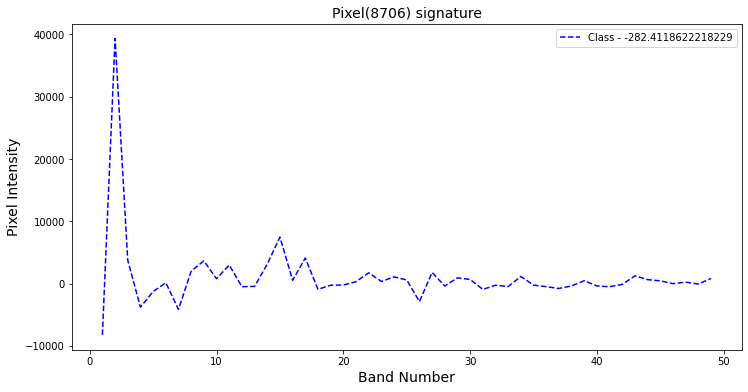

In [83]:
plot_signature(proj_df)

In [82]:
print(ETR(X,y11, band_no, status, sigma, numComponents))

                0             1            2            3            4   \
0     -8599.139470  38930.687321  3836.298276 -3953.688608 -1360.159389   
1     -9185.617097  42411.001233  3558.867576 -3354.027636 -1943.947792   
2     -9380.368687  43477.946064  3418.460115 -3122.282637 -2055.797514   
3     -9170.437766  42756.927129  3552.725349 -3379.805915 -1942.415004   
4     -8605.223975  40047.946996  3932.003198 -3789.925648 -1427.355340   
...            ...           ...          ...          ...          ...   
21020  3903.320257  42193.227601  3631.403918 -4105.730246 -1722.346898   
21021  4163.291160  42219.458141  3509.492478 -3973.543025 -1397.313943   
21022  3785.601178  41519.930815  3510.811163 -3976.621484 -1436.299116   
21023  2912.853610  39589.309682  3232.172289 -3685.587687 -1028.928615   
21024  2986.227508  40040.799947  3443.538013 -3984.698287 -1242.971683   

               5            6            7            8           9   ...  \
0      230.147125 -422